#### All imports here:

In [238]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

#### Reading data set

In [239]:
# For the purpose of the project, I imported the file from my google drive while using google colab.
# I have added the dataset file 'yahoo_dataset.csv' in the github repo.
# However, if you still wish to access the file from your google drive, then
# you can execute the following code on google colab signed into the same account
# as the google drive that you wish to access.

# from google.colab import drive
# drive.mount('/content/drive', force_remount=True)

In [240]:
# Load the dataset
# train_data = pd.read_csv('/content/drive/MyDrive/infinite-data/history.csv')

In [241]:
train_data = pd.read_csv("./datasets/history.csv")
train_data.head()

/var/folders/gk/qw9z66_x6f568n5ry11rsp980000gn/T/ipykernel_50635/600742029.py:1: DtypeWarning: Columns (87) have mixed types. Specify dtype option on import or set low_memory=False.
  train_data = pd.read_csv("./datasets/history.csv")


,id,type_code,is_registered,country_code,currency_code,is_active,class_id,debit_code,last_trade_date,contract_type,...,is_hrdc_resp,is_plan_grandfathered,resp_specimen_plan,inserted_at,updated_at,is_olob,retail_last_maintenance_time,retail_last_maintenance_user,visible_in_reports,label
0,893724,CASH SWEEP,f,NaN,CAD,t,3.0,0,NaN,NaN,...,NaN,NaN,NaN,2023-05-30 14:20:18.531115+00,2023-08-08 18:53:01.439561+00,f,NaN,NaN,f,Churn
1,1268094,RRIF,t,NaN,CAD,t,5.0,C,2022-07-04,18.0,...,f,f,NaN,2023-05-30 14:20:18.531115+00,2023-08-10 21:47:25.370403+00,f,2023-01-03 0:00,BATCH,t,Churn
2,606613,SPOUSAL RRSP,t,NaN,CAD,t,5.0,A,2018-07-05,16.0,...,f,f,NaN,2023-05-30 14:20:18.531115+00,2023-08-10 21:47:25.370403+00,f,2018-07-17 0:00,GUERINO,f,Churn
3,741930,CASH,f,NaN,CAD,t,3.0,T,NaN,12.0,...,NaN,NaN,NaN,2023-05-30 14:20:18.531115+00,2023-08-08 18:53:01.439561+00,f,NaN,NaN,t,Churn
4,1137922,CASH,f,NaN,CAD,t,3.0,T,NaN,17.0,...,NaN,NaN,NaN,2023-05-30 14:20:18.531115+00,2023-08-08 20:52:08.352646+00,f,NaN,NaN,f,Churn


In [242]:
info_df = pd.read_csv("account_data_info.csv")
pd.set_option('display.max_colwidth', None)
info_df

,Columns,Description,Field Values
0,type_code,Account Type,CSH - Cash/RSP (note: Registered accounts are account type CSH; plan type is determined by PLAN IND)
1,is_registered,NaN,MRL - Margin - Long
2,country_code,NaN,MRS - Margin - Short
3,currency_code,Currency of the Accoun,COD - Cash on Delivery
4,is_active,NaN,COM - Commodity
...,...,...,...
106,updated_at,NaN,NaN
107,is_olob,NaN,NaN
108,retail_last_maintenance_time,NaN,NaN
109,retail_last_maintenance_user,NaN,NaN


#### Dropping Columns and Research

In [243]:
# Aditya Parekh:
# I am removing these columns because they have 600k+ NULL values.
rem_cols_na = ['country_code', 'cashflows_custody_fee', 'arp_pension_origin', 'sss_location']
# I am removing these columns because they have 0 NULL values, but only one unique value.
rem_cols_one_uniq = ['net_of_fees', 'fee_paid_separately', 'custody_fee_withdrawal', 'is_fee_exempt']
# The following columns are NULL when 'class_id' = NULL. DON'T REMOVE THESE YET.
null_3198_cols = ['debit_code', 'last_trade_date', 'contract_type', 'inception_date',
             'branch', 'credit_limit_type', 'retail_plan', 'language_code', 'dividend_confirm_code']

In [244]:
# Aditya Mani:
# 1. esir_number: Contains 673327 missing values and cannot be imputed (has very little unique values)
# 2. shareholder_language: Contains 623554 missing values. Says whether the shareholder speaks English or French and there seems to be an equal proportion.
# 3. has_no_min_commission: No Null values and only 1 unique value.
# 4. rep_commission_rate: 1 unique value and few missing values that cannot be imputed.
# 5. spousal_age_flag: No Null values and only 1 unique value.
# 6. is_parameters_account: No Null values and only 1 unique value.
# 7. rrsp_limit_reached: No Null values and only 1 unique value.
# 8. is_portfolio_account: No Null values and only 1 unique value.
# 9. sss_type: Lot of missing values
# 10. sss_agent: Lot of missing values
# 11. target_grantor_grantee_flag: Missing values
# 12. terminal_code: Missing values

to_drop = ['esir_number', 'shareholder_language', 'has_no_min_commission', 'rep_commission_rate',
           'spousal_age_flag', 'is_parameters_account', 'rrsp_limit_reached', 'is_portfolio_account',
             'sss_type', 'sss_agent', 'target_grantor_grantee_flag', 'terminal_code']

missing_3198 = ['options_trading_type',
 'is_midwest_clearing_account',
 'rep_commission_override',
 'interest_dividend_conversion_type',
 'guarantee_gtor_type',
 'deceased_fair_market_value',
 'iso_funds_code']

In [245]:
# Jithin Krishna:

# Has too many null values
# last_update_date is the maintaineance date and was deemed not relevant to the churn
drop_cols = ["special_tag", "conjunction", "title", "function_code" ,"tms_settlement_location", "loan_limit_override", "last_update_date"]

# These values have 1 unique value and is not useful and hence shall be dropped
drop_uniq_cols = ["portfolio_cost_method", "portfolio_name_address_option", "portfolio_summary_option","interactive_portfolio_code"]

drop_3198_cols = ["portfolio_report_option", "mailing_consent"]

In [246]:
# Srishti Prayag:
# remove columns with more than 300,000 missing values
too_many_nans = ['special_fee_code', 'resp_specimen_plan', 'plan_end_date', 'retail_last_maintenance_user']

# list of columns with exactly 316985 missing values; may be connected so don't drop yet
nan_316985_columns = ['is_pledged', 'non_calendar_year_end', 'plan_effective_date', 'is_resp', 'number_of_beneficiaries', 'rrif_original_date', 'use_original_date_for_payment_calc', 'is_family_resp', 'is_hrdc_resp', 'retail_last_maintenance_time']

# list of columns with only 1 unique value
only_one_unique = ['is_plan_grandfathered', 'is_gl_account', 'is_control_account']

In [247]:
rem_cols = []
rem_cols.extend(rem_cols_na)
rem_cols.extend(rem_cols_one_uniq)
rem_cols.extend(to_drop)
rem_cols.extend(drop_cols)
rem_cols.extend(drop_uniq_cols)
rem_cols.extend(too_many_nans)
rem_cols.extend(only_one_unique)
train_data = train_data.drop(rem_cols, axis=1)

In [248]:
# Drop rows where column 'class_id' is NaN
train_data = train_data.dropna(subset=['class_id'])

In [249]:
train_data.to_csv("./cleaned_data.csv", index=False)

In [250]:
# Aditya & Jithin - Imputations/Deletions
# is_arp_locked impute all NaN with 'f'
# remove 'is_spousal', 'last_trade_date' columns for insufficient data
# has_discrete_auth impute all NaN with 't'
# contract_type remove rows where NaN
# last_maintenance_time remove rows where NaN
# discretionary_trading_authorized impute all NaNs with 'n'.
# type_code inpute most frequent
# dup_trip_quad_code is being removed because it has only one unique value and 12 missing values (insignificant)

train_data['is_arp_locked'] = train_data['is_arp_locked'].fillna('f')
train_data = train_data.drop(['is_spousal', 'last_trade_date', 'dup_trip_quad_code'], axis=1)
train_data = train_data.dropna(subset=['contract_type'])
train_data = train_data.dropna(subset=['last_maintenance_time'])
train_data['has_discrete_auth'] = train_data['has_discrete_auth'].fillna('t')
train_data['discretionary_trading_authorized'] = train_data['discretionary_trading_authorized'].fillna('n')
train_data['type_code'] = train_data['type_code'].fillna(train_data['type_code'].mode()[0])
train_data.head()


,id,type_code,is_registered,currency_code,is_active,class_id,debit_code,contract_type,inception_date,branch,...,rrif_original_date,use_original_date_for_payment_calc,is_family_resp,is_hrdc_resp,inserted_at,updated_at,is_olob,retail_last_maintenance_time,visible_in_reports,label
1,1268094,RRIF,t,CAD,t,5.0,C,18.0,2018-11-08,IAVM,...,2018-11-08,f,f,f,2023-05-30 14:20:18.531115+00,2023-08-10 21:47:25.370403+00,f,2023-01-03 0:00,t,Churn
2,606613,SPOUSAL RRSP,t,CAD,t,5.0,A,16.0,2009-04-08,IAVM,...,2009-04-08,f,f,f,2023-05-30 14:20:18.531115+00,2023-08-10 21:47:25.370403+00,f,2018-07-17 0:00,f,Churn
3,741930,CASH,f,CAD,t,3.0,T,12.0,2021-01-04,IAVM,...,NaN,NaN,NaN,NaN,2023-05-30 14:20:18.531115+00,2023-08-08 18:53:01.439561+00,f,NaN,t,Churn
4,1137922,CASH,f,CAD,t,3.0,T,17.0,2017-07-21,IAVM,...,NaN,NaN,NaN,NaN,2023-05-30 14:20:18.531115+00,2023-08-08 20:52:08.352646+00,f,NaN,f,Churn
5,1020597,REG RRSP,t,CAD,t,5.0,C,9.0,2017-07-21,IAVM,...,2017-07-21,f,f,f,2023-05-30 14:20:18.531115+00,2023-08-10 21:47:25.370403+00,f,2019-10-02 0:00,t,Churn


In [251]:
# Srishti & Adi - Imputations/Deletions
# 1. retail_last_maintenance_time, non_calendar_year_end: Drop the column
# 2. is_resp, is_hrdc_resp, retail_plan: Group by type_code and fill the missing values with the mode of the group
# 3. is_family_resp: If type_code is RESP and number_of_beneficiaries is greater than 1, then fill with 't' else 'f'
# 4. use_original_date_for_payment_calc - if RESP in type_code then t, else f
# 5. rrif_original_date, plan_effective_date: Fill with inception_date (default)
# 6. number_of_beneficiaries: Fill with 0 (assuming no beneficiaries)
# 7. is_pledged, non_plan_book_value: Fill with N (default)
# Code:
train_data = train_data.drop(['retail_last_maintenance_time', 'non_calendar_year_end'], axis=1)
train_data['is_resp'] = train_data.groupby('type_code')['is_resp'].transform(lambda x: x.fillna(x.mode().iloc[0] if not x.mode().empty else 'f'))
train_data['is_hrdc_resp'] = train_data.groupby('type_code')['is_hrdc_resp'].transform(lambda x: x.fillna(x.mode().iloc[0] if not x.mode().empty else 'f'))
train_data['is_family_resp'] = np.where((train_data['type_code'] == 'RESP') & (train_data['number_of_beneficiaries'] > 1), 't', 'f')
train_data['retail_plan'] = train_data.groupby('type_code')['retail_plan'].transform(lambda x: x.fillna(x.mode().iloc[0] if not x.mode().empty else 'N/A'))
train_data['use_original_date_for_payment_calc'] = np.where(train_data['type_code'] == 'RESP', 't', 'f')
train_data['rrif_original_date'] = train_data['rrif_original_date'].fillna(train_data['inception_date'])
train_data['number_of_beneficiaries'] = train_data['number_of_beneficiaries'].fillna(0.0)
train_data['plan_effective_date'] = train_data['plan_effective_date'].fillna(train_data['inception_date'])
train_data['is_pledged'] = train_data['is_pledged'].fillna('N')
train_data['non_plan_book_value_flag'] = train_data['non_plan_book_value_flag'].fillna('N')
train_data.head()

,id,type_code,is_registered,currency_code,is_active,class_id,debit_code,contract_type,inception_date,branch,...,number_of_beneficiaries,rrif_original_date,use_original_date_for_payment_calc,is_family_resp,is_hrdc_resp,inserted_at,updated_at,is_olob,visible_in_reports,label
1,1268094,RRIF,t,CAD,t,5.0,C,18.0,2018-11-08,IAVM,...,0.0,2018-11-08,f,f,f,2023-05-30 14:20:18.531115+00,2023-08-10 21:47:25.370403+00,f,t,Churn
2,606613,SPOUSAL RRSP,t,CAD,t,5.0,A,16.0,2009-04-08,IAVM,...,0.0,2009-04-08,f,f,f,2023-05-30 14:20:18.531115+00,2023-08-10 21:47:25.370403+00,f,f,Churn
3,741930,CASH,f,CAD,t,3.0,T,12.0,2021-01-04,IAVM,...,0.0,2021-01-04,f,f,f,2023-05-30 14:20:18.531115+00,2023-08-08 18:53:01.439561+00,f,t,Churn
4,1137922,CASH,f,CAD,t,3.0,T,17.0,2017-07-21,IAVM,...,0.0,2017-07-21,f,f,f,2023-05-30 14:20:18.531115+00,2023-08-08 20:52:08.352646+00,f,f,Churn
5,1020597,REG RRSP,t,CAD,t,5.0,C,9.0,2017-07-21,IAVM,...,0.0,2017-07-21,f,f,f,2023-05-30 14:20:18.531115+00,2023-08-10 21:47:25.370403+00,f,t,Churn


In [252]:
# Risk Tolerance Data Engineering
train_data['low_risk'] = 0
train_data['medium_risk'] = 0
train_data['high_risk'] = 0
train_data['risk_tolerance'].fillna(train_data['risk_tolerance'].mode()[0], inplace=True)

train_data['risk_tolerance'] = train_data['risk_tolerance'].astype(str)

def extract_risk_tolerance(risk_tolerance):
    low_risk = 0
    medium_risk = 0
    high_risk = 0

    for i in range(0, len(risk_tolerance), 3):
        if risk_tolerance[i] in ['B', 'X', 'L']:
            low_risk += int(risk_tolerance[i+1:i+3])
        elif risk_tolerance[i] in ['G', 'C', 'M']:
            medium_risk += int(risk_tolerance[i+1:i+3])
        elif risk_tolerance[i] in ['S', 'D', 'H']:
            high_risk += int(risk_tolerance[i+1:i+3])
        else:
            medium_risk += int(risk_tolerance[i+1:i+3])

    return pd.Series({'low_risk': low_risk, 'medium_risk': medium_risk, 'high_risk': high_risk})

train_data[['low_risk', 'medium_risk', 'high_risk']] = train_data['risk_tolerance'].apply(extract_risk_tolerance)
train_data = train_data.drop('risk_tolerance', axis=1)

In [253]:
# Investment Objective Data Engineering
# Columns: Income, Growth, Speculation, Liquidity, Safety
# If the column is NaN, fill with the mode of the column

train_data['income'] = 0
train_data['growth'] = 0
train_data['speculation'] = 0
train_data['liquidity'] = 0
train_data['safety'] = 0
train_data['investment_objective'].fillna(train_data['investment_objective'].mode()[0], inplace=True)
train_data['investment_objective'] = train_data['investment_objective'].astype(str)

def extract_investment_obj(investment_objective):
    income = 0
    growth = 0
    speculation = 0
    liquidity = 0
    safety = 0

    for i in range(0, len(investment_objective), 3):
        if investment_objective[i] in ['B']:
            income += int(investment_objective[i+1:i+3])
        elif investment_objective[i] in ['G', 'C']:
            growth += int(investment_objective[i+1:i+3])
        elif investment_objective[i] in ['D', 'S']:
            speculation += int(investment_objective[i+1:i+3])
        elif investment_objective[i] in ['M']:
            liquidity += int(investment_objective[i+1:i+3])
        elif investment_objective[i] in ['X']:
            safety += int(investment_objective[i+1:i+3])
        else:
            growth += int(investment_objective[i+1:i+3])

    return pd.Series({'income': income, 'growth': growth, 'speculation': speculation, 'liquidity': liquidity, 'safety': safety})

train_data[['income', 'growth', 'speculation', 'liquidity', 'safety']] = train_data['investment_objective'].apply(extract_investment_obj)
train_data = train_data.drop('investment_objective', axis=1)

In [254]:
# Missing Values Check
missing_values_train = train_data.isnull().sum()
value_counts = train_data.nunique()
missing_values_train = pd.concat([missing_values_train, value_counts], axis=1)
missing_values_train.columns = ['Missing Values', 'Value Counts']
missing_values_train = missing_values_train[missing_values_train['Missing Values'] > 0]
missing_values_train = missing_values_train.sort_values(by='Missing Values', ascending=False)
missing_values_train

,Missing Values,Value Counts


In [255]:
# Convert all date columns to contain the total number of months between today's date and provided date.

# Convert all date columns to datetime
train_data['rrif_original_date'] = pd.to_datetime(train_data['rrif_original_date'])
train_data['plan_effective_date'] = pd.to_datetime(train_data['plan_effective_date'])
train_data['inception_date'] = pd.to_datetime(train_data['inception_date'])
train_data['last_maintenance_time'] = pd.to_datetime(train_data['last_maintenance_time'])

current_date = datetime(2024, 2, 22)

# Calculate time difference in months from today's date
train_data['rrif_months'] = ((current_date - train_data['rrif_original_date']) / pd.Timedelta(days=30)).astype(int)
train_data['plan_effective_months'] = ((current_date - train_data['plan_effective_date']) / pd.Timedelta(days=30)).astype(int)
train_data['inception_months'] = ((current_date - train_data['inception_date']) / pd.Timedelta(days=30)).astype(int)
train_data['months_last_maintenance'] = ((current_date - train_data['last_maintenance_time']) / pd.Timedelta(days=30)).astype(int)

# Drop the original date columns
train_data.drop(columns=['rrif_original_date', 'plan_effective_date', 'inception_date', 'last_maintenance_time'], inplace=True)

In [256]:
# Use the OrdinalEncoder to convert labels into values
ordinal_encoder = OrdinalEncoder()
label_encoder = LabelEncoder()

# Drop 'id' column from dataset as it is not needed for training the model
to_encode = train_data.drop(columns=['id'], inplace=False)

# Extract input features (X) and output labels (y)
X = to_encode.drop(columns=['label'])  # Input features
y = to_encode['label']  # Output labels

# Identify categorical features to be encoded (excluding output label)
categorical_features = X.select_dtypes(include=['object']).columns.tolist()

# Fit the encoder to the dataset and transform it
X[categorical_features] = ordinal_encoder.fit_transform(X[categorical_features])

encoded_array_y = label_encoder.fit_transform(y)
y = pd.Series({"label" : encoded_array_y})

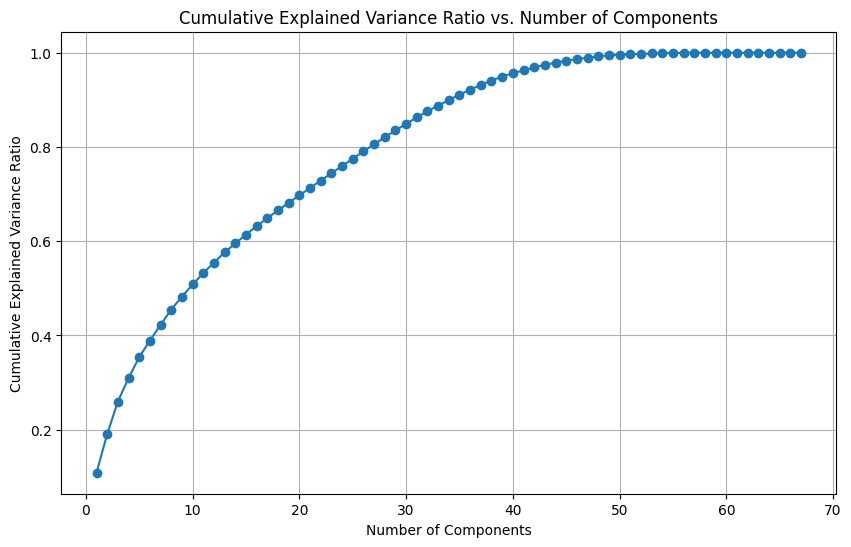

In [257]:
# Apply PCA to reduce the number of features
# to choose the number of components, we can use the elbow method
# Scale the features

scaler = StandardScaler()
X = scaler.fit_transform(X)
pca = PCA()
pca.fit(X)
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance_ratio = np.cumsum(explained_variance_ratio)

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_variance_ratio) + 1), cumulative_variance_ratio, marker='o', linestyle='-')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title('Cumulative Explained Variance Ratio vs. Number of Components')
plt.grid(True)
plt.show()


In [258]:
# Deciding number of components = 35 from the plot
components = 35
pca = PCA(n_components=components)
X_reduced = pca.fit_transform(X)
X_reduced = pd.DataFrame(X_reduced, columns=[f"PC{i}" for i in range(1, components+1)])
X_reduced.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC26,PC27,PC28,PC29,PC30,PC31,PC32,PC33,PC34,PC35
0,1.777790,-1.240421,-0.912910,-0.488215,0.105202,0.955739,-0.375668,0.949837,0.789253,0.518213,...,-0.042102,-0.256445,0.107309,0.727158,-0.209381,0.324701,-0.344747,0.137949,0.218296,-0.132658
1,1.861678,3.938988,-2.022564,3.469002,-1.127755,-1.235882,0.237283,-1.258882,-0.732921,-1.159724,...,-21.424511,12.012299,0.374709,-0.606352,3.406103,1.264531,-1.051516,1.179509,1.127914,-2.155598
2,-3.010847,-1.070971,0.608507,-2.462952,-0.553495,0.801688,-0.645267,0.836107,1.479369,0.227356,...,-0.000672,0.137417,-0.204332,-0.335704,0.265945,-0.499796,-0.035030,-0.324294,-0.235988,0.601770
3,-2.208204,-0.141348,0.606155,-1.681941,-0.840427,-1.191193,0.476998,-0.514618,-0.412414,-1.561496,...,-0.044498,-0.095209,0.306846,-0.388246,0.819228,0.872339,0.323665,-0.873418,-0.204827,0.396246
4,1.420962,-0.404545,-0.981982,0.170306,0.313442,1.530834,-0.698189,0.114148,0.444599,0.987691,...,-0.186186,-0.483632,-0.190882,0.732358,-1.257567,-0.235312,-0.208052,0.370618,-0.067242,0.057130


In [264]:
X_reduced.describe()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC26,PC27,PC28,PC29,PC30,PC31,PC32,PC33,PC34,PC35
count,5.773140e+05,5.773140e+05,5.773140e+05,5.773140e+05,5.773140e+05,5.773140e+05,5.773140e+05,5.773140e+05,5.773140e+05,5.773140e+05,...,5.773140e+05,5.773140e+05,5.773140e+05,5.773140e+05,5.773140e+05,5.773140e+05,5.773140e+05,5.773140e+05,5.773140e+05,5.773140e+05
mean,1.112127e-16,4.509554e-17,6.749562e-17,1.171696e-17,-1.328251e-16,-7.207409e-17,-2.119884e-16,1.734160e-16,1.582036e-16,1.897606e-16,...,-3.746474e-17,-1.060434e-16,1.684929e-16,-1.041850e-16,-7.276333e-17,1.045665e-16,-8.770492e-17,-2.782779e-17,-9.628341e-17,5.008633e-17
std,2.637434e+00,2.288719e+00,2.105178e+00,1.780636e+00,1.691124e+00,1.498434e+00,1.461825e+00,1.442642e+00,1.322445e+00,1.288604e+00,...,9.915209e-01,9.881470e-01,9.830578e-01,9.523840e-01,9.477029e-01,9.385772e-01,9.053769e-01,8.818417e-01,8.687810e-01,8.589724e-01
min,-6.015370e+00,-6.488570e+00,-5.573515e+00,-4.499000e+00,-1.191825e+01,-4.980717e+00,-2.734435e+00,-6.641187e+00,-1.005378e+01,-7.717913e+00,...,-2.291147e+01,-2.144484e+01,-3.442213e+01,-1.064598e+01,-1.481521e+01,-1.031217e+01,-1.160666e+01,-1.344705e+01,-2.097423e+01,-1.440820e+01
25%,-2.796714e+00,-1.457462e+00,-1.132354e+00,-1.146483e+00,-5.773066e-01,-1.186955e+00,-5.937970e-01,-7.820960e-01,-7.649389e-01,-7.199789e-01,...,-1.497600e-01,-2.537293e-01,-1.418693e-01,-5.039995e-01,-5.327311e-01,-4.832132e-01,-4.530883e-01,-5.389112e-01,-2.032430e-01,-2.274726e-01
50%,1.343450e+00,-4.433244e-01,-6.116133e-01,-4.150466e-01,-1.047068e-01,4.008281e-01,-1.658154e-01,7.077589e-03,2.015232e-01,7.969020e-02,...,-1.562089e-02,-3.681927e-02,6.725155e-02,1.807091e-02,-1.147670e-02,2.207426e-02,-8.565549e-03,-8.102041e-02,-1.489055e-02,6.629881e-02
75%,1.915823e+00,9.084736e-01,7.186930e-01,7.826266e-01,3.048034e-01,1.039292e+00,4.751518e-01,8.496710e-01,9.268741e-01,6.844715e-01,...,1.002785e-01,1.931667e-01,2.620268e-01,4.961743e-01,5.182442e-01,5.194117e-01,4.885234e-01,4.579116e-01,1.619069e-01,3.210153e-01
max,1.552493e+01,1.744091e+01,3.073983e+01,9.647463e+00,2.072122e+01,2.447478e+01,5.222015e+01,6.783823e+00,1.562976e+01,2.121663e+01,...,4.010207e+01,4.503775e+01,1.715799e+02,3.416078e+01,1.623899e+01,1.687835e+01,3.283036e+01,1.356826e+01,5.170874e+01,3.093720e+01


/var/folders/gk/qw9z66_x6f568n5ry11rsp980000gn/T/ipykernel_50635/1139920602.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = train_data.corr()


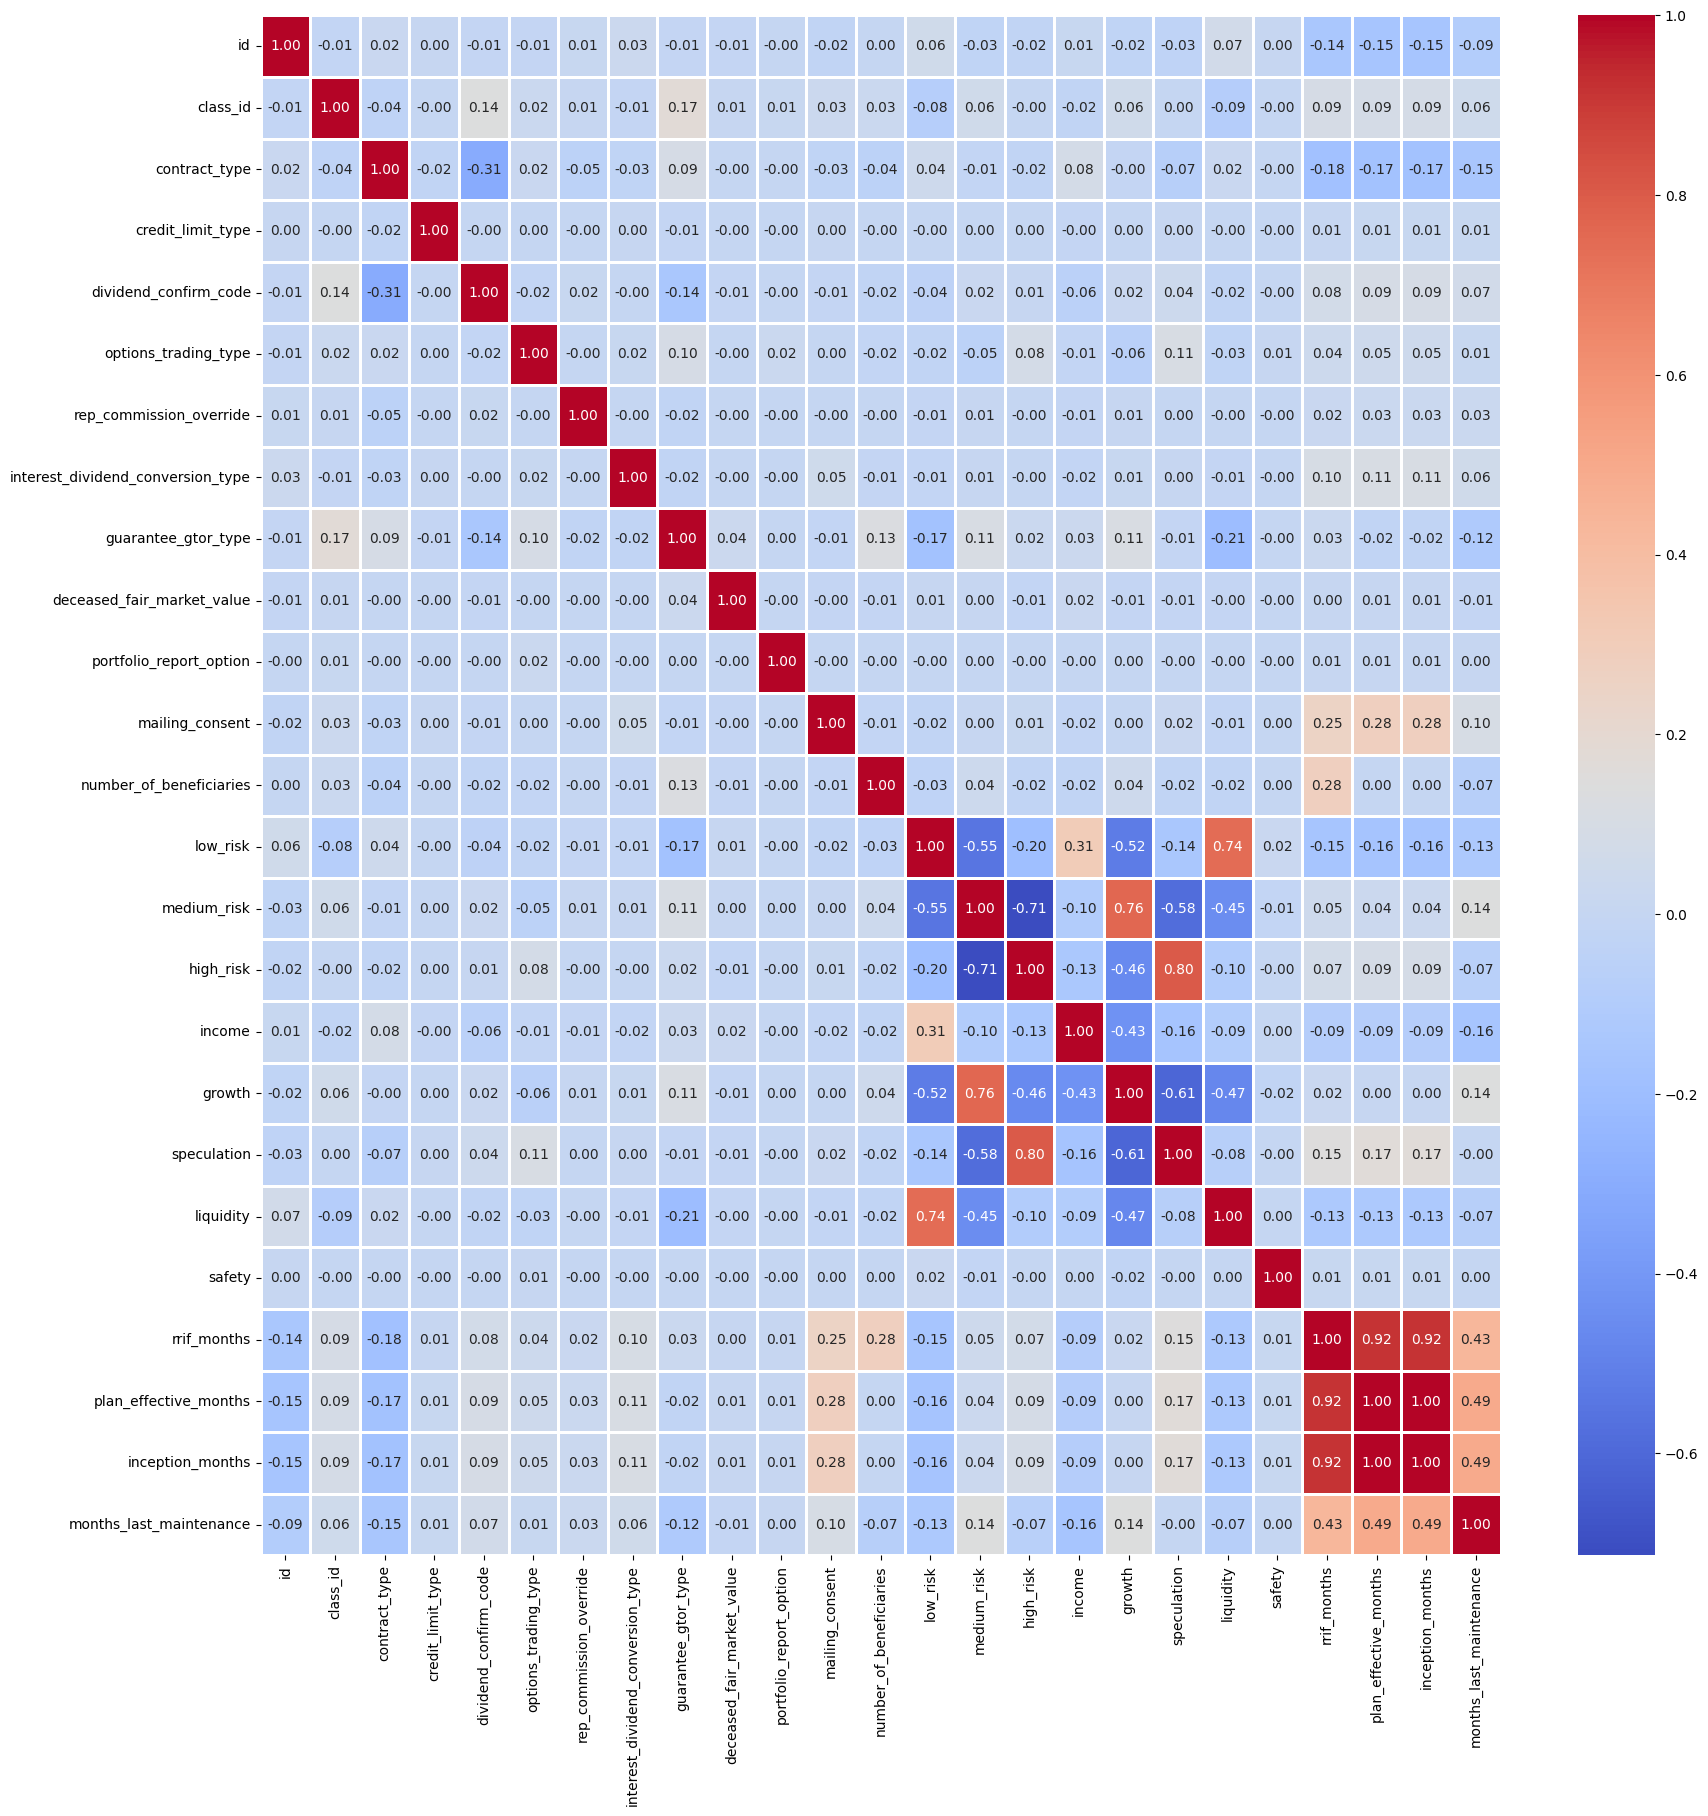

In [260]:
# Corelation Matrix
corr = train_data.corr()
plt.figure(figsize=(20, 20))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f', linewidths=2)
plt.show()

In [261]:
missing_values_train = train_data.isnull().sum()
value_counts = train_data.nunique()
missing_values_train = pd.concat([missing_values_train, value_counts], axis=1)
missing_values_train.columns = ['Missing Values', 'Value Counts']
# missing_values_train = missing_values_train[missing_values_train['Missing Values'] > 0]
missing_values_train = missing_values_train.sort_values(by='Value Counts', ascending=False)
missing_values_train

,Missing Values,Value Counts
id,0,577314
deceased_fair_market_value,0,2044
last_maintenance_user,0,429
rrif_months,0,362
inception_months,0,322
...,...,...
use_client_address,0,2
consent_to_email_delivery,0,2
is_olob,0,1
is_midwest_clearing_account,0,1


In [262]:
# missing_values_train = X.isnull().sum()
# value_counts = X.nunique()
# missing_values_train = pd.concat([missing_values_train, value_counts], axis=1)
# missing_values_train.columns = ['Missing Values', 'Value Counts']
# # missing_values_train = missing_values_train[missing_values_train['Missing Values'] > 0]
# missing_values_train = missing_values_train.sort_values(by='Value Counts', ascending=False)
# missing_values_train